This notebook trains the CWW+SB4 templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d
from scipy.signal import medfilt

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Load the CWW+SB4 templates

In [97]:
cwwsb4_templates = dict()
step = 100
lambda_min = 10
lambda_max = 15000

x, y = np.loadtxt('templates/El_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['El'] = sed

x, y = np.loadtxt('templates/Sbc_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Sbc'] = sed

x, y = np.loadtxt('templates/Scd_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Scd'] = sed

x, y = np.loadtxt('templates/Im_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Im'] = sed

x, y = np.loadtxt('templates/SB3_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['SB3'] = sed

x, y = np.loadtxt('templates/SB2_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['SB2'] = sed

# note I will lower the spectral line in SB2 because it creates problems in
# the template training
template = cwwsb4_templates['SB2']
idx = np.fabs(template.wavelen-5000).argmin()
template.flambda[idx] /= 4

x, y = np.loadtxt('templates/ssp_25Myr_z008.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['25Myr'] = sed

x, y = np.loadtxt('templates/ssp_5Myr_z008.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['5Myr'] = sed

Create training sets and plot them

In [7]:
%%time
training_sets = create_training_sets(cwwsb4_templates, galaxies, bandpass_dict)

CPU times: user 2min, sys: 281 ms, total: 2min
Wall time: 2min


Number of fluxes in each training set:
[41510, 81323, 131477, 82804, 47103, 24726, 2605, 180]


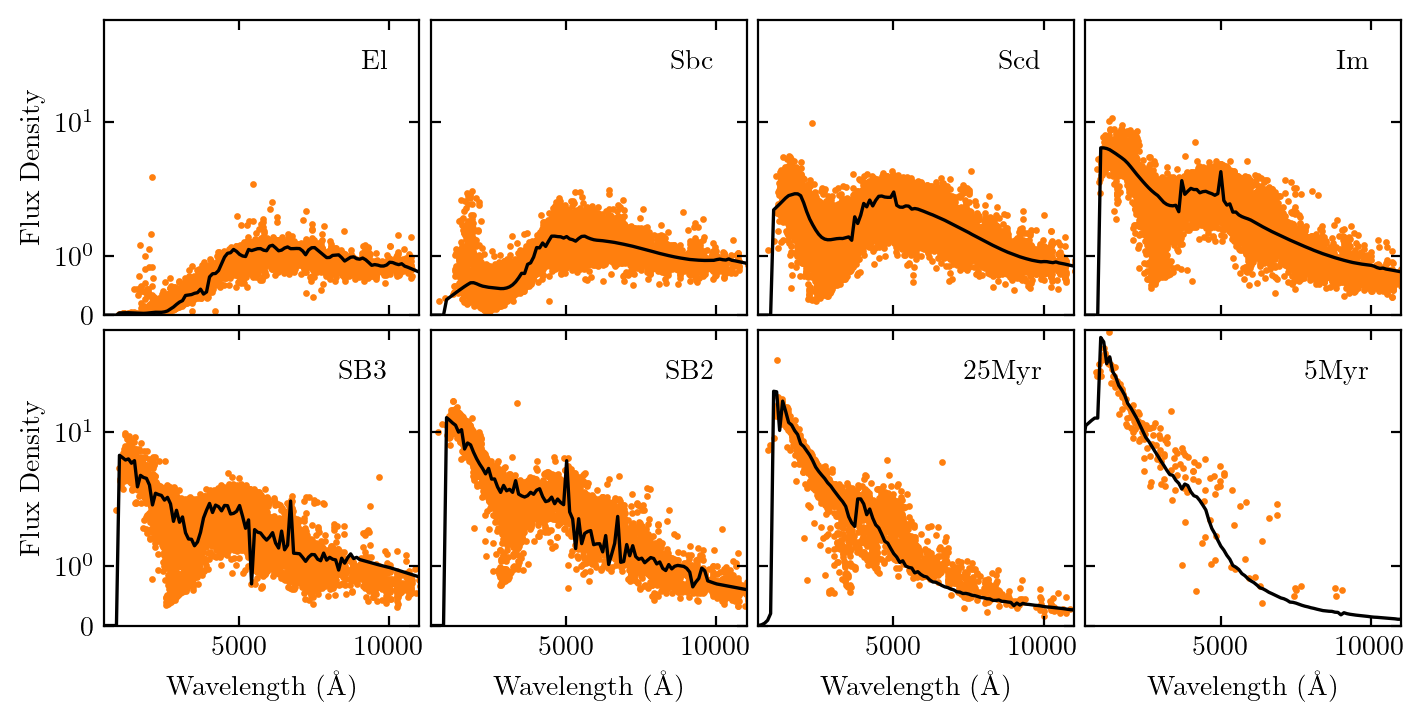

In [8]:
fig, axes = plt.subplots(2,4,sharex='all',sharey='all',figsize=(twocol,twocol*1/2))

print("Number of fluxes in each training set:")
print([len(i) for i in training_sets.values()])

for (ax,template) in zip(axes.flatten(),cwwsb4_templates):
    
    wavelen = [row[0] for row in training_sets[template]]
    fluxes = [row[1] for row in training_sets[template]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    sed = cwwsb4_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,template,transform=ax.transAxes,ha="right",va="top")

plt.xlim(500,11000)
plt.ylim(0,90)
plt.yscale('symlog')

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/cwwsb4_untrained.png')

Now train the templates

In [9]:
%%time
trained_templates, final_sets, history = train_templates(cwwsb4_templates, galaxies, bandpass_dict, w=2, dmse_stop=0.03, renorm=False, verbose=True)

Round 1
El:   37.3   31.4   30.4   29.9  
Sbc:   65.7   57.9   57.3  
Scd:  148.0  139.9  138.8  
Im:  247.7  226.4  223.3  
SB3:  249.8  222.1  218.9  
SB2:  815.3  734.3  718.0  
25Myr: 2766.8 2117.5 2024.4 2004.5  
5Myr: 75659.0 48131.4 44505.3 42719.3 41374.5 40336.0  
Round 2
El:   28.9   28.1  
Sbc:   57.9  
Scd:  130.6  124.1  123.4  
Im:  182.5  175.6  174.3  
SB3:  184.2  174.7  173.3  
SB2:  511.9  496.3  492.2  
25Myr: 1627.4 1518.8 1489.4  
5Myr: 26472.6 17501.2 16272.9 15957.8  
Round 3
El:   29.2   28.7  
Sbc:   57.9  
Scd:  129.3  124.8  124.2  
Im:  186.5  181.8  
SB3:  179.8  171.2  170.1  
SB2:  431.2  416.7  413.3  
25Myr: 1625.5 1588.3  
5Myr: 14431.4 13908.0 13732.5  
Round 4
El:   27.8   27.4  
Sbc:   59.0  
Scd:  138.1  132.6  131.9  
Im:  182.4  
SB3:  172.8  
SB2:  422.9  
25Myr: 4370.5 4331.5  
5Myr: 6925.2 6608.2 6510.0  
Round 5
El:   28.8   28.4  
Sbc:   60.4  
Scd:  138.0  134.1  
Im:  174.9  171.5  
SB3:  168.7  
SB2:  436.6  425.0  
25Myr: 4374.7  
5Myr:

Save the results!

In [13]:
for template in trained_templates:
    file = open('templates/'+template+'_trained.sed','w')
    x = copy.copy(trained_templates[template].wavelen)
    y = copy.copy(trained_templates[template].flambda)
    # upsample to every 10 angstroms
    xnew = np.arange(x[0],x[-1],10)
    ynew = np.interp(xnew,x,y)
    for i in range(len(xnew)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(xnew[i],ynew[i]))
    file.close()
    
f = open("templates/cwwsb4_training_history.pkl","wb")
pickle.dump(history,f)
f.close()

Plot the results

In [6]:
""""# Load the trained templates from files if you didn't run the training algorithm
trained_templates = dict()
for template in cwwsb4_templates:
    x,y = np.loadtxt('templates/'+template+'_trained.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(trained_templates, galaxies, bandpass_dict)"""";

Number of fluxes in each training set:
[48954, 50425, 46804, 81264, 63698, 73399, 12370, 34814]


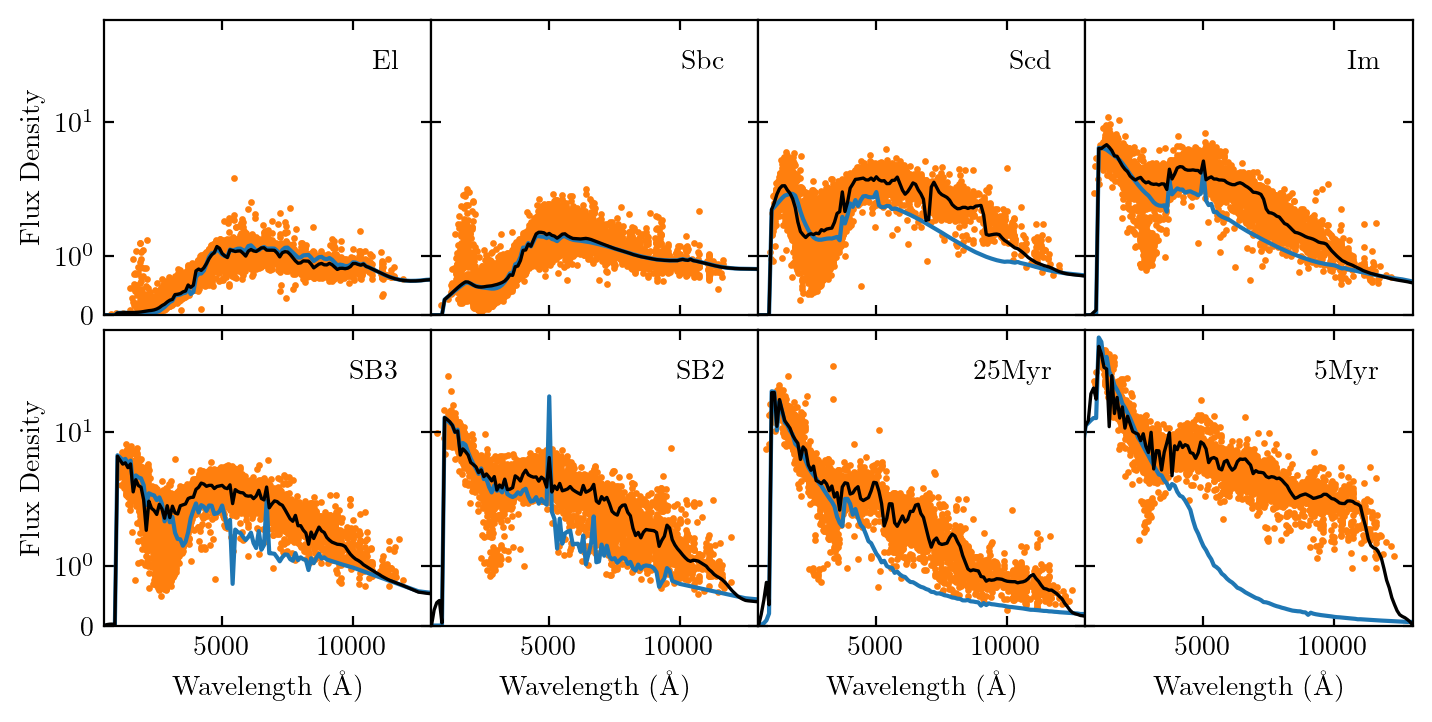

In [18]:
fig, axes = plt.subplots(2,4,sharex='all',sharey='all',figsize=(twocol,1/2*twocol))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for (ax,template) in zip(axes.flatten(),trained_templates):
    
    wavelen = [row[0] for row in final_sets[template]]
    fluxes = [row[1] for row in final_sets[template]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    sed = cwwsb4_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="C0", lw=1.5)
    
    sed = trained_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,template,transform=ax.transAxes,ha="right",va="top")

plt.xlim(500,13000)
plt.ylim(0,90)
plt.yscale('symlog')#,linthreshy=3)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/cwwsb4_trained.png')

Now I will renormalize the templates around 5000 angstroms

In [93]:
original_normed = copy.deepcopy(cwwsb4_templates)
trained_normed = copy.deepcopy(trained_templates)

# restore the big spectral line in SB2
x, y = np.loadtxt('templates/SB2_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
original_normed['SB2'] = sed

# now renorm all the templates around 5000 angstroms

for template in original_normed.values():
    Y = medfilt(template.flambda)
    idx = np.fabs(template.wavelen - 5000).argmin()
    template.flambda /= Y[idx]

for template in trained_normed.values():
    Y = medfilt(template.flambda,kernel_size=9)
    idx = np.fabs(template.wavelen - 5000).argmin()
    template.flambda /= Y[idx]
    
normed_sets = create_training_sets(trained_normed, galaxies, bandpass_dict)

Number of fluxes in each training set:
[48954, 50425, 46804, 81264, 63698, 73399, 12370, 34814]


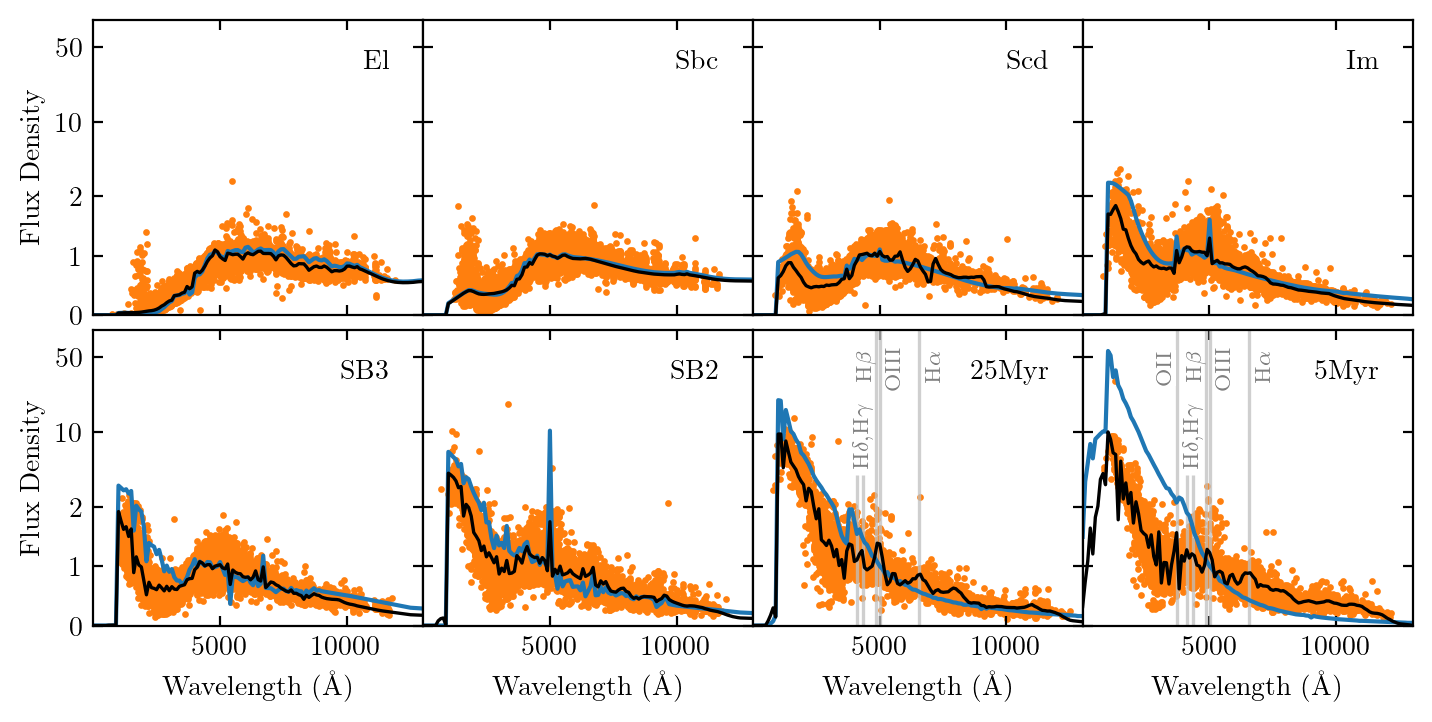

In [128]:
fig, axes = plt.subplots(2,4,sharex='all',sharey='all',figsize=(twocol,1/2*twocol))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for (ax,template) in zip(axes.flatten(),trained_templates):
    
    wavelen = [row[0] for row in normed_sets[template]]
    fluxes = [row[1] for row in normed_sets[template]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    sed = original_normed[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="C0", lw=1.5)
    
    sed = trained_normed[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,template,transform=ax.transAxes,ha="right",va="top")
    
# Feature lines
axes_ = axes.flatten()
box_style = dict(facecolor='white', edgecolor='none', pad=0)
# Halpha
for i in [7,8]:
    axes_[i-1].vlines(6563,0,90,color='silver',alpha=0.75) # Halpha
    axes_[i-1].text(6763,40,r"H$\alpha$",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center',bbox=box_style)
# Hbeta
for i in [7,8]:    
    axes_[i-1].vlines(4861,0,90,color='silver',alpha=0.75) # Hbeta
    axes_[i-1].text(4861,40,r"H$\beta$",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center')
# OIII
for i in [7,8]:
    axes_[i-1].vlines(5007,0,90,color='silver',alpha=0.75) # OIII
    axes_[i-1].text(5207,40,"OIII",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center')
# OII
for i in [8]:
    axes_[i-1].vlines(3727,0,90,color='silver',alpha=0.75) # OII
    axes_[i-1].text(3677,40,"OII",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center',bbox=box_style)
# Hdelta and Hgamma
for i in [7,8]:
    axes_[i-1].vlines(4102,0,4,color='silver',alpha=0.75) # Hdelta
    axes_[i-1].vlines(4340,0,4,color='silver',alpha=0.75) # Hgamma
    axes_[i-1].text(4352,4.5,r"H$\delta$,H$\gamma$",fontsize=8,rotation=90,
                    color='gray',ha='center',va='bottom',bbox=box_style)

plt.xlim(10,13000)
plt.ylim(0,90)
plt.yscale('symlog')

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    ax.set_yticks([0,1,2,10,50])
    ax.set_yticklabels([0,1,2,10,50])
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/cwwsb4_trained.png')